In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    torchvision.transforms.Grayscale(num_output_channels=1)
])

#dataloader
train_path =  r"C:\Datasets\Train_set"
test_path = r"C:\Datasets\Test_set"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=48, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=24, shuffle=True
)
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

cuda
['stage1', 'stage2', 'stage3', 'stage4', 'stage5', 'stage6', 'stage7', 'stage8', 'stage9']


In [2]:
import torch
import torch.nn as nn
from math import ceil

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(1, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [3]:
model=EfficientNet("b0", num_classes=9).to(device)
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

77626 23645


In [4]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [5]:
y_pred = []
y_true = []
train_losses = []
test_accuracies = []
best_accuracy= 0.0
test_accuracy=0.0
train_accuracy=0.0
train_loss=0.0

In [6]:
def train_test(start_epochs, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred):
    #Model training and saving best model

    for epoch in range(start_epochs, num_epochs+1):

        #Evaluation and training on training dataset
        model.train()

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count

        # Evaluation on testing dataset
        model.eval()

        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
        
        train_losses.append(train_loss.item())
        test_accuracies.append(test_accuracy)
        checkpoint = {
                'start_epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_loss': train_loss,
                'train_losses':train_losses,
                'test_accuracies': test_accuracies,
                'y_true': y_true,
                'y_pred': y_pred
        }
        save_ckp(checkpoint, False, checkpoint_path='current_checkpoint_efficientNet_b0_StageWise.pt', best_model_path='best_checkpoint_efficientNet_b0_StageWise.model')
        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint_efficientNet_b0_StageWise.model')
            best_accuracy=test_accuracy
            checkpoint['best_accuracy']=best_accuracy
            save_ckp(checkpoint, True, checkpoint_path='current_checkpoint_efficientNet_b0_StageWise.pt', best_model_path='best_checkpoint_efficientNet_b0_StageWise.model')

In [7]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_accuracy = checkpoint['best_accuracy']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    train_loss = checkpoint['train_loss']    
    train_losses = checkpoint['train_losses']    
    test_accuracies = checkpoint['test_accuracies']   
    start_epoch = checkpoint['start_epoch']
    y_true = checkpoint['y_true']
    y_pred = checkpoint['y_pred']
    return model, optimizer,start_epoch,best_accuracy, train_accuracy,test_accuracy,train_loss.item(),train_losses,test_accuracies,y_true,y_pred

In [8]:
def conf_matrix(y_true,y_pred):
     # constant for classes
    
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

In [9]:
def learn_curve_train_losses(train_losses):
    plt.plot(train_losses,'-o')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train'])
    plt.title('Train Losses Per Epoch')

    plt.show()
    
def learn_curve_test_accuracies(test_accuracies):
    plt.plot(test_accuracies,'-r')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.legend(['Test Accuracy'])
    plt.title('Test Accuracy Per Epoch')
    plt.show()


In [ ]:
num_epochs = 40

import os.path

if os.path.isfile("current_checkpoint_effecientNet_b0_StageWise.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0_StageWise.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 1 Train Loss: tensor(1.4922) Train Accuracy: 0.3834668796537243 Test Accuracy: 0.40820469443857055
Epoch: 2 Train Loss: tensor(1.1179) Train Accuracy: 0.5375052619854128 Test Accuracy: 0.5488436542480203
Epoch: 3 Train Loss: tensor(0.9038) Train Accuracy: 0.6418794927635326 Test Accuracy: 0.6426537891162718
Epoch: 4 Train Loss: tensor(0.7377) Train Accuracy: 0.7182470033170942 Test Accuracy: 0.711340353300449
Epoch: 5 Train Loss: tensor(0.6193) Train Accuracy: 0.7637095592585386 Test Accuracy: 0.7307553960817637
Epoch: 6 Train Loss: tensor(0.5333) Train Accuracy: 0.7989947145229596 Test Accuracy: 0.7262732398137485
Epoch: 7 Train Loss: tensor(0.4686) Train Accuracy: 0.8242702057907727 Test Accuracy: 0.7565542936451604
Epoch: 8 Train Loss: tensor(0.4240) Train Accuracy: 0.8425762537063071 Test Accuracy: 0.7735993467664896
Epoch: 9 Train Loss: tensor(0.3832) Train Accuracy: 0.858769517639112 Test Accuracy: 0.7873450454365305
Epoch: 10 Train Loss: tensor(0.3585) Train Accuracy: 0.8

In [10]:
num_epochs = 40

import os.path

if os.path.isfile("current_checkpoint_effecientNet_b0_StageWise.pt"):
    ckp_path = "current_checkpoint_efficientNet_b0_StageWise.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)

Epoch: 1 Train Loss: tensor(1.5134) Train Accuracy: 0.3720274134954783 Test Accuracy: 0.41755127934024105
Epoch: 2 Train Loss: tensor(1.1306) Train Accuracy: 0.530329683706664 Test Accuracy: 0.5390322500012409
Epoch: 3 Train Loss: tensor(0.8666) Train Accuracy: 0.6539887451328641 Test Accuracy: 0.6344063874920702
Epoch: 4 Train Loss: tensor(0.6836) Train Accuracy: 0.7326624325450898 Test Accuracy: 0.7206865894010359
Epoch: 5 Train Loss: tensor(0.5766) Train Accuracy: 0.7777385497440619 Test Accuracy: 0.6953994792382914
Epoch: 6 Train Loss: tensor(0.5000) Train Accuracy: 0.8115164730702309 Test Accuracy: 0.7067327299420274
Epoch: 7 Train Loss: tensor(0.4443) Train Accuracy: 0.8332879642964093 Test Accuracy: 0.7517321519445946
Epoch: 8 Train Loss: tensor(0.4023) Train Accuracy: 0.8509756175503607 Test Accuracy: 0.7634490053775405
Epoch: 9 Train Loss: tensor(0.3717) Train Accuracy: 0.8628017800172306 Test Accuracy: 0.7537222858534732
Epoch: 10 Train Loss: tensor(0.3435) Train Accuracy: 0.

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

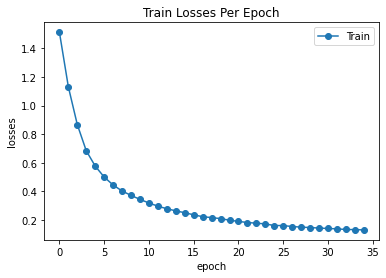

In [11]:
learn_curve_train_losses(train_losses)

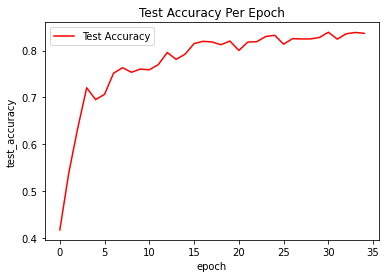

In [12]:
learn_curve_test_accuracies(test_accuracies)

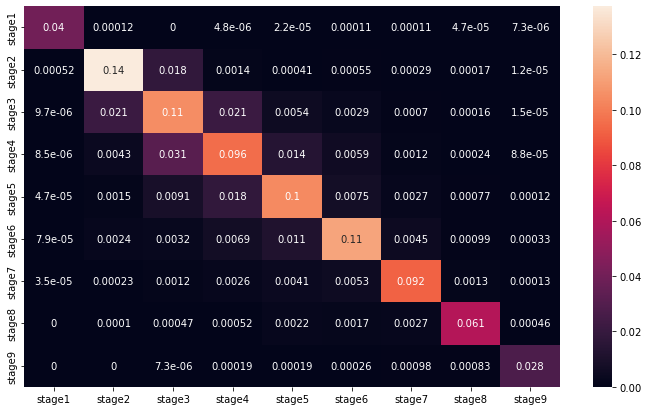

In [13]:
conf_matrix(y_true,y_pred)